<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" style="height:450px;" width=500/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>
<h3 style="text-align: center;"><b>Продвинутый поток. Весна 2021</b></h3>

<h1 style="text-align: center;"><b>Трансформеры. GPT2.</b></h1>

## BPE


**Проблема**

 - Токенизация слов слишком высокоуровнева
 - Токенизация по буквам слишком низкоуровнева


 **Решение**

 Будем соединять токены, пока не достигнем определенного числа.

![](https://lena-voita.github.io/resources/lectures/seq2seq/bpe/build_merge_table.gif)

In [ ]:
!pip install -q youtokentome
!pip install -q datasets

     |████████████████████████████████| 1.7MB 5.8MB/s 
     |████████████████████████████████| 194kB 6.1MB/s 
     |████████████████████████████████| 245kB 34.1MB/s 
     |████████████████████████████████| 112kB 44.3MB/s 


In [ ]:
from datasets import load_dataset
from youtokentome import BPE

In [ ]:
dataset = load_dataset("ag_news")

Using custom data configuration default


Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/fb5c5e74a110037311ef5e904583ce9f8b9fbc1354290f97b4929f01b3f48b1a. Subsequent calls will reuse this data.


In [ ]:
with open("data.txt", "w") as out:
    for data_d in dataset["train"]:
        out.write(data_d["text"]+"\n")

In [ ]:
bpe = BPE.train(data="data.txt", vocab_size=5000, model="bpe.bin")

In [ ]:
encoded = bpe.encode("Hello there! What is BPE?")

In [ ]:
tokenized = ""
for word in encoded:
    tokenized += " " + bpe.id_to_subword(word)
tokenized

' ▁H ell o ▁there ! ▁What ▁is ▁B P E ?'

## GPT 2


### Encoder vs Decoder

![](http://armancohan.com/img/transformer-1.png)

Так в чем разница?


![](http://jalammar.github.io/images/gpt2/self-attention-and-masked-self-attention.png)

## Авторегрессионный трансформер

![](http://jalammar.github.io/images/xlnet/gpt-2-autoregression-2.gif)

In [ ]:
import torch
from torch import nn

### Attention implementation


<img src="http://jalammar.github.io/images/gpt2/gpt2-self-attention-2.png" width="800">

In [ ]:
def get_qkv(self, inp):
    qkv = self.c_attn(inp)
    return qkv

<img src="http://jalammar.github.io/images/gpt2/gpt2-self-attention-3.png" width="800">

In [ ]:
def split_qkv(self, inp):
    return inp.split(self.split_size, dim=2)

<img src="http://jalammar.github.io/images/gpt2/gpt2-self-attention-split-attention-heads-1.png" width="800">

In [ ]:
def split_heads(self, q, k, v):

    batch_s = q.size(0)
    seq_length = q.size(1)
    n_heads = self.n_heads
    feature_dim = q.size(-1)
    head_features_size = feature_dim // n_heads

    # (batch_s, seq_length, feature_dim) -> (batch_s, seq_length, n_heads, head_features_size)
    new_x_shape = (batch_s, seq_length, n_heads, head_features_size) 

    q = q.view(*new_x_shape)
    k = k.view(*new_x_shape)
    v = v.view(*new_x_shape)

    #(batch_s, seq_length, n_heads, head_features_size) -> (batch, head, seq_length, head_features)

    q = q.permute(0, 2, 1, 3)  # (batch, head, seq_length, head_features)
    k = k.permute(0, 2, 3, 1)  # k = k^T
    v = v.permute(0, 2, 1, 3)  # (batch, head, seq_length, head_features)

    return q, k , v

<img src=http://jalammar.github.io/images/gpt2/gpt2-self-attention-scoring-2.png width=800>

<img src=http://jalammar.github.io/images/gpt2/gpt2-self-attention-multihead-sum-1.png width=800>

$$ \text{Softmax}(\frac{Q\cdot K^T}{\sqrt{d}}) \cdot V$$

In [ ]:
def attn(self, q, k, v):
    w = torch.matmul(q, k) # q @ k^T
    d = float(v.size(-1))
    w /= d**0.5
    scores = torch.softmax(w, dim=-1)
    result = torch.matmul(scores, v)
    return result, scores
    

<img src=http://jalammar.github.io/images/gpt2/gpt2-self-attention-merge-heads-1.png width=800>



In [ ]:
def merge_heads(self, w):
    batch_size = w.size(0)
    w = w.permute(0, 2, 1, 3)  # (batch_size, seq_length, head_num(12), head_features(64))
    w = w.contiguous()  # reallocate tensor
    seq_length = w.size(1)
    # (batch_size, seq_length, head_num(12), head_features(64)) -> (batch_size, seq_length, feature_dim(12*64=768))
    w = w.view(batch_size, seq_length, w.size(-2)*w.size(-1))
    return w

<img src=http://jalammar.github.io/images/gpt2/gpt2-self-attention-project-2.png width=800>



In [ ]:
def project(self, w):
    return self.c_proj(w)

<img src=http://jalammar.github.io/images/gpt2/gpt2-self-attention-qkv-3-2.png width=800>


In [ ]:
class Attention(nn.Module):
    def __init__(self, emb_dim:int = 768, n_heads: int = 12):
        super().__init__()
        n_state = emb_dim
        self.n_heads = n_heads
        self.split_size = n_state
        self.c_attn = nn.Linear(emb_dim, 3 * emb_dim)
        self.c_proj = nn.Linear(emb_dim, emb_dim)
        self.emb_dim = emb_dim

    def forward(
        self,
        hidden_states,
        layer_past=None,
        use_cache=False,
        output_attentions=False,
    ):
        qkv = get_qkv(self, hidden_states)  # self.get_qkv(*args) -> get_qkv(self, *args)
        query, key, value = split_qkv(self, qkv) # (, , feature_dim)
        query, key, value = split_heads(self, query, key, value)  # (, n_heads, seq_length, head_feature_dim)

        if layer_past is not None:
            past_key, past_value = layer_past[0].transpose(-2, -1), layer_past[1]  # transpose back cf below
            key = torch.cat((past_key, key), dim=-1)
            value = torch.cat((past_value, value), dim=-2)

        attn_outputs = attn(self, query, key, value)
        a = attn_outputs[0] # features
        scores = attn_outputs[1]  # scores

        a = merge_heads(self, a)  # (batch_size, seq_length, feature_dim(768))
        a = project(self, a)  # (batch_size, seq_length, feature_dim(768))
        outputs = [a]
        if use_cache:
            present = torch.stack((key.transpose(-2, -1), value))  # transpose to have same shapes for stacking
        else:
            present = (None,)
        outputs.append(present)
        if output_attentions:
            outputs.append(scores)
        

        return outputs

### Feed Forward

<img src=http://jalammar.github.io/images/gpt2/gpt2-mlp1.gif width=800>

<img src=http://jalammar.github.io/images/gpt2/gpt2-mlp-2.gif width=800>


In [ ]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, emb_dim: int = 768):
        super().__init__()
        self.c_fc = nn.Linear(emb_dim, emb_dim * 4)
        self.activ = nn.ReLU()
        self.c_proj = nn.Linear(emb_dim * 4, emb_dim)

    def forward(self, inp):
        inp = self.c_fc(inp)
        inp = self.activ(inp)
        return self.c_proj(inp)

<img src=http://jalammar.github.io/images/gpt2/gpt2-transformer-block-weights-2.png width=800>



### Decoder Block

In [ ]:
class Block(nn.Module):
    def __init__(self, emb_dim, n_heads):
        super().__init__()
        hidden_size = emb_dim
        # emb_dim = n_heads * head_feature_dim
        self.ln_1 = nn.LayerNorm(hidden_size, eps=1e-5)
        self.attn = Attention(hidden_size, n_heads=n_heads)
        self.ln_2 = nn.LayerNorm(hidden_size, eps=1e-5)
        inner_dim = hidden_size
        self.ff = FeedForwardNetwork(inner_dim)

    def forward(
        self,
        hidden_states,
        layer_past=None,
        use_cache=False,
        output_attentions=False,
    ):
        attn_outputs = self.attn(
            self.ln_1(hidden_states),
            layer_past=layer_past,
            use_cache=use_cache,
            output_attentions=output_attentions,
        )
        attn_output = attn_outputs[0]  # output_attn: a, present, (attentions)
        outputs = attn_outputs[1:]
        # residual connection
        hidden_states = attn_output + hidden_states

        feed_forward_hidden_states = self.ff(self.ln_2(hidden_states))
        # residual connection
        hidden_states = hidden_states + feed_forward_hidden_states

        outputs = [hidden_states] + outputs
        return outputs  # hidden_states, present, (attentions)

In [ ]:
block = Block(emb_dim=768, n_heads=12)
block(torch.randn(16, 128, 768))[0].shape

torch.Size([16, 128, 768])

In [ ]:
# Conv1D(n_state, nx) ~ nn.Linear(nx, n_state)

## Huggingface's transformers

![](https://raw.githubusercontent.com/huggingface/transformers/master/docs/source/imgs/transformers_logo_name.png)

In [ ]:
!pip install -q transformers

     |████████████████████████████████| 2.2MB 5.2MB/s 
     |████████████████████████████████| 3.3MB 25.4MB/s 
     |████████████████████████████████| 870kB 48.8MB/s 


In [ ]:
import torch

from transformers import GPT2LMHeadModel
from transformers import GPT2Tokenizer

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")
ru_gpt = GPT2LMHeadModel.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2", output_attentions=True)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
ru_gpt.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50264, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): Laye

In [ ]:
start = tokenizer.encode(
    "В банке можно заказать кофе", 
    return_tensors="pt"
)

result = ru_gpt.generate(
    start.to(device), 
    max_length=20,
    top_p=0.8,
    early_stopping=True, 
    no_repeat_ngram_size=2,
)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
print(tokenizer.decode(result.cpu().flatten().numpy(), skip_special_tokens=True))

В банке можно заказать кофе, чай, кофе-машину, а также кофеварку. 


## Внутри Attention

In [ ]:
import sys
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
# !rm -r bertviz_repo # Uncomment if you need a clean pull from repo
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']
!pip install regex

Cloning into 'bertviz_repo'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 1312 (delta 64), reused 63 (delta 28), pack-reused 1203
Receiving objects: 100% (1312/1312), 213.58 MiB | 21.65 MiB/s, done.
Resolving deltas: 100% (827/827), done.


In [ ]:
from bertviz import model_view
from transformers import GPT2Tokenizer, GPT2Model

In [ ]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/5.7.0/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

In [ ]:
text = tokenizer.decode(result.cpu().flatten().numpy(), skip_special_tokens=True)
inputs = tokenizer.encode_plus(text, return_tensors='pt', add_special_tokens=True)
input_ids = inputs['input_ids']
attention = ru_gpt(input_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
call_html()
model_view(attention, tokens)

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np

def get_attention_matrixes(model, tokenizer, text, device="cpu"):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))
    
    return np.array(attn)

In [ ]:
generated = tokenizer.decode(
    result.cpu().flatten().numpy(), 
    skip_special_tokens=True
)

attn = get_attention_matrixes(ru_gpt, tokenizer, generated)

In [ ]:
seq = [tokenizer.decode([result.numpy().flatten()[i]]) for i in range(20)]

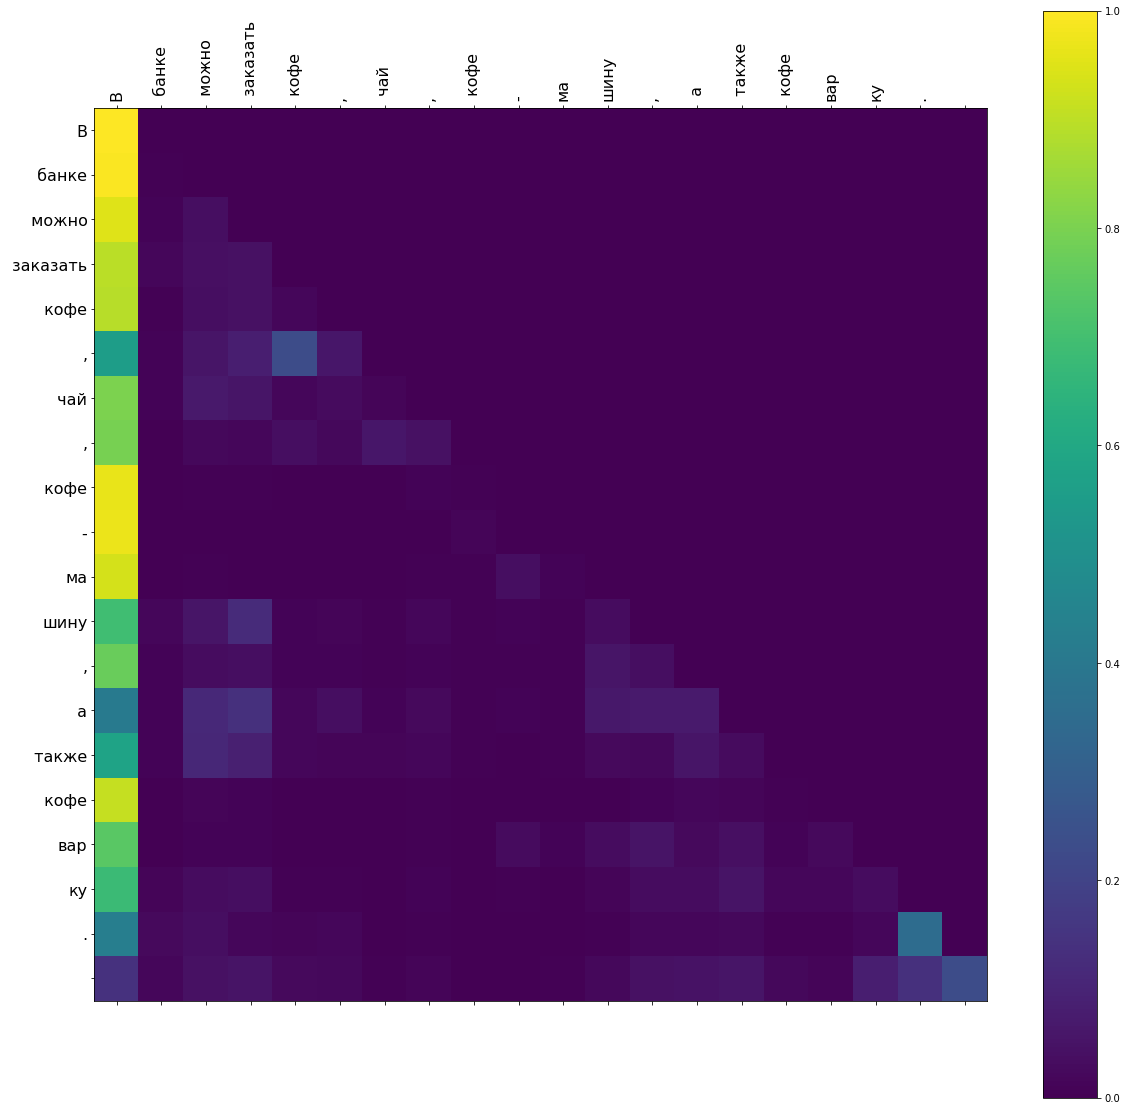

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import ticker

def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

show_attention(seq, attn[9][0])

In [ ]:
inp = """
один плюс один равно два
Два плюс три равно пять
три плюс четыре 
"""

encoded = tokenizer.encode(inp, return_tensors="pt")


result = ru_gpt.generate(encoded, max_length=30)

print(tokenizer.decode(result.cpu().flatten().numpy(), skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



один плюс один равно два
Два плюс три равно пять
три плюс четыре 
















# Полезные ссылки

1. https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html
2. http://jalammar.github.io/illustrated-transformer/
3. http://jalammar.github.io/illustrated-gpt2/
